In [2]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import seaborn as sns



In [26]:
filepath = '/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/udp_regressions/'
udp_2017 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/reference/udp_2017results.csv')
rec1_vars_dummies = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/demog_with_cra_dummies_201314.csv').drop("Total Loans", axis=1)
loans_09 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/2009_loans.csv')
loans_1314 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/201314_loans.csv')
loans_151617 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/20151617_loans.csv')
display(loans_1314.head())
display(loans_151617.head())
display(loans_09.head())
rec1_vars_dummies.columns

,Geoid,Total loans 2013-2014,% Loans to MHI borrowers
0,6001400100,144,0.986111
1,6001400200,47,1.000000
2,6001400300,123,1.000000
3,6001400400,104,0.980769
4,6001400500,90,0.922222


,Geoid,Total loans 2015-2017,% Loans to MHI borrowers
0,6001400100,209,0.995215
1,6001400200,45,1.000000
2,6001400300,140,1.000000
3,6001400400,112,0.991071
4,6001400500,134,0.947761


,Geoid,Total loans 2009,% Loans to MHI borrowers
0,6001400100,55,0.981818
1,6001400200,20,1.000000
2,6001400300,64,0.906250
3,6001400400,48,0.979167
4,6001400500,57,0.877193


Index(['Geoid',
       'Percent of population 25 years and over with Bachelor's degree',
       '% below poverty level', '% Single Family', '% Owner Occupied',
       'Percent NH White alone', 'Percent NH Black or African African alone',
       'Percent NH Asian alone', 'Percent Hispanic',
       'Total number of housing units', 'Median home value', 'Median income',
       'Year_x', 'Tract_y', 'type', 'CRA Eligible', 'CRA',
       'County_Alameda County', 'County_Contra Costa County',
       'County_Marin County', 'County_Napa County',
       'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Clara County', 'County_Solano County',
       'County_Sonoma County'],
      dtype='object')

In [4]:
rec1_udp_merge = pd.merge(rec1_vars_dummies, udp_2017, how='left', right_on='geo_fips', left_on='Geoid')
all_vars_09 = pd.merge(rec1_udp_merge, loans_09, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)
all_vars_1314 = pd.merge(rec1_udp_merge, loans_1314, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)
all_vars_151617 = pd.merge(rec1_udp_merge, loans_151617, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)


In [5]:
def encode_udp(row):
    if (row == 'MHI - Advanced Gentrification'):
        return 6
    elif (row == 'LI - Ongoing Gentrification and/or Displacement'):
        return 5     
    elif (row == 'LI - At Risk of Gentrification and/or Displacement'):
        return 4    
    elif (row == 'MHI - Not Losing Low Income Households' or row == 'LI - Not Losing Low Income Households'):
        return 3 
    else:
        return np.nan #this includes all of the exclusion typologies, college town, or unreliable data


In [29]:
all_vars_09["UDP code"] = all_vars_09["Typology"].apply(lambda x: encode_udp(x))
all_vars_09 = all_vars_09.dropna()
x_vars_2009 = all_vars_09[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", "Total loans 2009",
                "Total number of housing units",  "Median home value", 'Median income',
                           'County_Alameda County', 'County_Contra Costa County','County_Marin County', 
                  'County_Napa County','County_San Francisco County', 'County_San Mateo County',
       'County_Santa Clara County', 'County_Solano County','County_Sonoma County']]
x_vars_2009_constant = sm.add_constant(x_vars_2009)

y_vars_2009 = all_vars_09["UDP code"]
x_vars_2009.head()

,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total loans 2009,Total number of housing units,Median home value,Median income,County_Alameda County,County_Contra Costa County,County_Marin County,County_Napa County,County_San Francisco County,County_San Mateo County,County_Santa Clara County,County_Solano County,County_Sonoma County
1,0.906250,0,0.321,0.069,0.478758,0.714142,64,2801,718100.0,66638.0,1,0,0,0,0,0,0,0,0
2,0.979167,0,0.440,0.040,0.555446,0.698082,48,2020,790500.0,80391.0,1,0,0,0,0,0,0,0,0
3,0.877193,1,0.281,0.060,0.444380,0.419526,57,1735,572000.0,50658.0,1,0,0,0,0,0,0,0,0
4,0.870968,1,0.519,0.264,0.632653,0.338305,31,784,586700.0,39802.0,1,0,0,0,0,0,0,0,0
5,0.714286,1,0.194,0.081,0.572421,0.356832,119,2016,511600.0,32471.0,1,0,0,0,0,0,0,0,0


In [31]:
mn = sm.MNLogit(y_vars_2009, x_vars_2009_constant, J=4, K=20)
results_mn = mn.fit()
print(results_mn.summary())
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/udp_regressions/2009_udp_multinomial_newgeos.html', 'w') as outfile:
    outfile.write(results_mn.summary().as_html())

         Current function value: 0.874150
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               UDP code   No. Observations:                  739
Model:                        MNLogit   Df Residuals:                      682
Method:                           MLE   Df Model:                           54
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                  0.2954
Time:                        10:14:22   Log-Likelihood:                -646.00
converged:                      False   LL-Null:                       -916.84
                                        LLR p-value:                 1.157e-81
                   UDP code=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0360   4.44e+06  -8.11e-09      1.000   -8.69e+06    8.69e+06
% Loans 

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
all_vars_1314["UDP code"] = all_vars_1314["Typology"].apply(lambda x: encode_udp(x))
all_vars_1314 = all_vars_1314.dropna()
#do not include napa county
x_vars_1314 = all_vars_1314[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total loans 2013-2014', 'County_Alameda County', 'County_Contra Costa County','County_Marin County', 
                  'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Clara County', 'County_Solano County','County_Sonoma County']]
x_vars_1314_constant = sm.add_constant(x_vars_1314)

y_vars_1314 = all_vars_1314["UDP code"]
x_vars_1314_constant.head()


,const,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2013-2014,County_Alameda County,County_Contra Costa County,County_Marin County,County_San Francisco County,County_San Mateo County,County_Santa Clara County,County_Solano County,County_Sonoma County
1,1.0,1.000000,0,0.321,0.069,0.478758,0.714142,2801,718100.0,66638.0,123,1,0,0,0,0,0,0,0
2,1.0,0.980769,0,0.440,0.040,0.555446,0.698082,2020,790500.0,80391.0,104,1,0,0,0,0,0,0,0
3,1.0,0.922222,1,0.281,0.060,0.444380,0.419526,1735,572000.0,50658.0,90,1,0,0,0,0,0,0,0
4,1.0,0.871429,1,0.519,0.264,0.632653,0.338305,784,586700.0,39802.0,70,1,0,0,0,0,0,0,0
5,1.0,0.912621,1,0.194,0.081,0.572421,0.356832,2016,511600.0,32471.0,206,1,0,0,0,0,0,0,0


In [13]:
mn = sm.MNLogit(y_vars_1314, x_vars_1314_constant, J=4, K=20)
results_mn1314 = mn.fit()
print(results_mn1314.summary())
with open(filepath+ '201314_udp_multinomial_newgeos.html', 'w') as outfile:
    outfile.write(results_mn1314.summary().as_html())

         Current function value: 0.876242
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               UDP code   No. Observations:                  739
Model:                        MNLogit   Df Residuals:                      682
Method:                           MLE   Df Model:                           54
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                  0.2937
Time:                        10:09:00   Log-Likelihood:                -647.54
converged:                      False   LL-Null:                       -916.84
                                        LLR p-value:                 4.684e-81
                   UDP code=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.5436      1.635      2.778      0.005       1.338       7.749
% Loans 

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [42]:
all_vars_1314_nc = all_vars_1314.copy()
all_vars_1314_nc["UDP code"] = all_vars_1314_nc["Typology"].apply(lambda x: encode_udp(x))
all_vars_1314_nc = all_vars_1314_nc.dropna()
#do not include napa county
x_vars_1314_nc = all_vars_1314_nc[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total loans 2013-2014']]
x_vars_1314_nc_constant = sm.add_constant(x_vars_1314_nc)

y_vars_1314_nc = all_vars_1314_nc["UDP code"]
x_vars_1314_nc_constant.head()


,const,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2013-2014
1,1.0,1.000000,0,0.321,0.069,0.478758,0.714142,2801,718100.0,66638.0,123
2,1.0,0.980769,0,0.440,0.040,0.555446,0.698082,2020,790500.0,80391.0,104
3,1.0,0.922222,1,0.281,0.060,0.444380,0.419526,1735,572000.0,50658.0,90
4,1.0,0.871429,1,0.519,0.264,0.632653,0.338305,784,586700.0,39802.0,70
5,1.0,0.912621,1,0.194,0.081,0.572421,0.356832,2016,511600.0,32471.0,206


In [43]:
nc = sm.MNLogit(y_vars_1314_nc, x_vars_1314_nc_constant, J=4, K=20)
results_nc1314 = nc.fit()
print(results_nc1314.summary())
with open(filepath+ '201314_udp_multinomial_nc_newgeos.html', 'w') as outfile:
    outfile.write(results_nc1314.summary().as_html())

Optimization terminated successfully.
         Current function value: 0.919705
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:               UDP code   No. Observations:                  739
Model:                        MNLogit   Df Residuals:                      706
Method:                           MLE   Df Model:                           30
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                  0.2587
Time:                        10:25:30   Log-Likelihood:                -679.66
converged:                       True   LL-Null:                       -916.84
                                        LLR p-value:                 2.149e-81
                   UDP code=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.4937      1.207      3.722      0.

In [33]:
all_vars_151617["UDP code"] = all_vars_151617["Typology"].apply(lambda x: encode_udp(x))
all_vars_151617 = all_vars_151617.dropna()
#do not include napa county
x_vars_151617 = all_vars_151617[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total loans 2015-2017', 'County_Alameda County', 'County_Contra Costa County','County_Marin County', 
                  'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Clara County', 'County_Solano County','County_Sonoma County']]
x_vars_151617_constant = sm.add_constant(x_vars_151617)
y_vars_151617 = all_vars_151617["UDP code"]
x_vars_151617_constant.head()

,const,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2015-2017,County_Alameda County,County_Contra Costa County,County_Marin County,County_San Francisco County,County_San Mateo County,County_Santa Clara County,County_Solano County,County_Sonoma County
1,1.0,1.000000,0,0.321,0.069,0.478758,0.714142,2801,718100.0,66638.0,140,1,0,0,0,0,0,0,0
2,1.0,0.991071,0,0.440,0.040,0.555446,0.698082,2020,790500.0,80391.0,112,1,0,0,0,0,0,0,0
3,1.0,0.947761,1,0.281,0.060,0.444380,0.419526,1735,572000.0,50658.0,134,1,0,0,0,0,0,0,0
4,1.0,1.000000,1,0.519,0.264,0.632653,0.338305,784,586700.0,39802.0,66,1,0,0,0,0,0,0,0
5,1.0,0.968468,1,0.194,0.081,0.572421,0.356832,2016,511600.0,32471.0,222,1,0,0,0,0,0,0,0


In [34]:
mn151617 = sm.MNLogit(y_vars_151617, x_vars_151617_constant, J=4, K=20)
results_mn151617 = mn151617.fit()
print(results_mn151617.summary())
with open(filepath+ '20151617_udp_multinomial_newgeos.html', 'w') as outfile:
    outfile.write(results_mn151617.summary().as_html())

         Current function value: 0.867482
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               UDP code   No. Observations:                  739
Model:                        MNLogit   Df Residuals:                      682
Method:                           MLE   Df Model:                           54
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                  0.3008
Time:                        10:14:35   Log-Likelihood:                -641.07
converged:                      False   LL-Null:                       -916.84
                                        LLR p-value:                 1.338e-83
                   UDP code=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             3.2540      1.785      1.823      0.068      -0.244       6.752
% Loans 

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# results_mn151617_margeff = results_mn151617.get_margeff()
 
# print(results_mn151617_margeff.summary())
# with open(filepath+ '20151617_udp_marginaleff.html', 'w') as outfile:
#     outfile.write(results_mn151617_margeff.summary().as_html())
    
    
    

#### Pairwise Correlations

In [35]:
x_vars_09_corr = x_vars_2009[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total loans 2009']].corr()
x_vars_09_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2009
% Loans to MHI borrowers,1.000000,-0.358729,0.703896,-0.405771,-0.093730,0.544389,0.194067,0.708225,0.471531,-0.301954
CRA,-0.358729,1.000000,-0.398729,0.502685,-0.339555,-0.383480,-0.015843,-0.290231,-0.602898,-0.086732
Pct Bachelor's degree,0.703896,-0.398729,1.000000,-0.413253,-0.156600,0.461804,0.221544,0.578136,0.491073,-0.234767
% below poverty level,-0.405771,0.502685,-0.413253,1.000000,-0.264359,-0.378048,-0.085869,-0.336139,-0.603070,-0.062314
% Single Family,-0.093730,-0.339555,-0.156600,-0.264359,1.000000,0.007342,-0.282186,0.171847,0.495243,0.290126


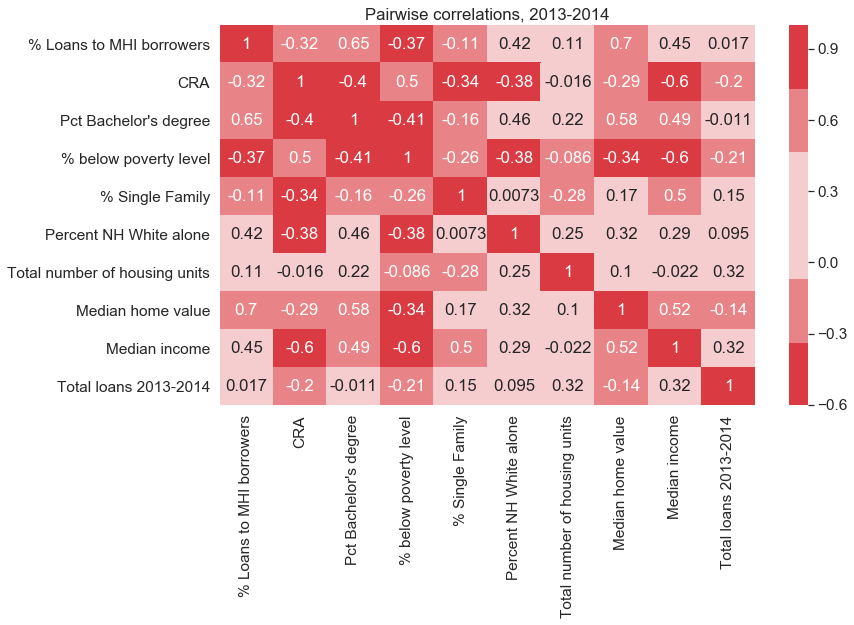

In [41]:
# color = sns.cubehelix_palette(8, start=.5, rot=-.75)
color = sns.diverging_palette(11, 11)
sns.set(font_scale=1.4)
plt.subplots(figsize=(12,7))
sns.heatmap(x_vars_1314_corr, annot=True, cmap=color);
plt.title("Pairwise correlations, 2013-2014")
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_09_corr.png', bbox_inches="tight")




In [16]:
x_vars_1314_corr = x_vars_1314[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total loans 2013-2014']].corr()
x_vars_1314_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2013-2014
% Loans to MHI borrowers,1.000000,-0.317489,0.647519,-0.374651,-0.106778,0.418109,0.113015,0.701357,0.450636,0.017019
CRA,-0.317489,1.000000,-0.398729,0.502685,-0.339555,-0.383480,-0.015843,-0.290231,-0.602898,-0.201899
Pct Bachelor's degree,0.647519,-0.398729,1.000000,-0.413253,-0.156600,0.461804,0.221544,0.578136,0.491073,-0.011249
% below poverty level,-0.374651,0.502685,-0.413253,1.000000,-0.264359,-0.378048,-0.085869,-0.336139,-0.603070,-0.205127
% Single Family,-0.106778,-0.339555,-0.156600,-0.264359,1.000000,0.007342,-0.282186,0.171847,0.495243,0.154461


Text(0.5, 1.0, 'Pairwise correlations, 2013-2014')

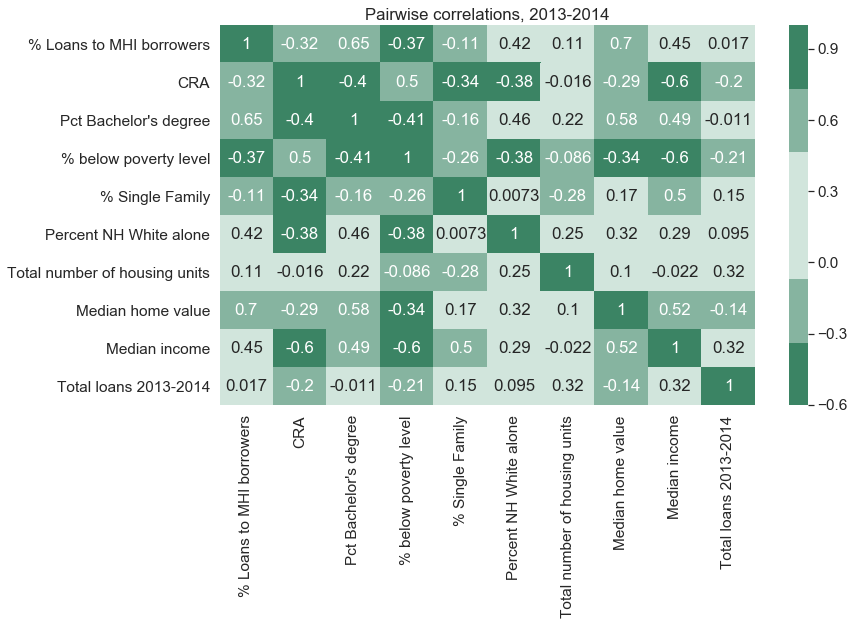

In [19]:
# color = sns.cubehelix_palette(8, start=.5, rot=-.75)
color = sns.diverging_palette(150, 150)
sns.set(font_scale=1.4)
plt.subplots(figsize=(12,7))
sns.heatmap(x_vars_1314_corr, annot=True, cmap=color);
plt.title("Pairwise correlations, 2013-2014")
# plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_1314_corr.png', bbox_inches="tight")




In [20]:

x_vars_151617_corr = x_vars_151617[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total loans 2015-2017']].corr()
x_vars_151617_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total loans 2015-2017
% Loans to MHI borrowers,1.000000,-0.294829,0.566739,-0.342806,-0.044779,0.318508,0.032717,0.641582,0.406627,-0.222136
CRA,-0.294829,1.000000,-0.398729,0.502685,-0.339555,-0.383480,-0.015843,-0.290231,-0.602898,-0.156266
Pct Bachelor's degree,0.566739,-0.398729,1.000000,-0.413253,-0.156600,0.461804,0.221544,0.578136,0.491073,-0.092425
% below poverty level,-0.342806,0.502685,-0.413253,1.000000,-0.264359,-0.378048,-0.085869,-0.336139,-0.603070,-0.136091
% Single Family,-0.044779,-0.339555,-0.156600,-0.264359,1.000000,0.007342,-0.282186,0.171847,0.495243,0.154926


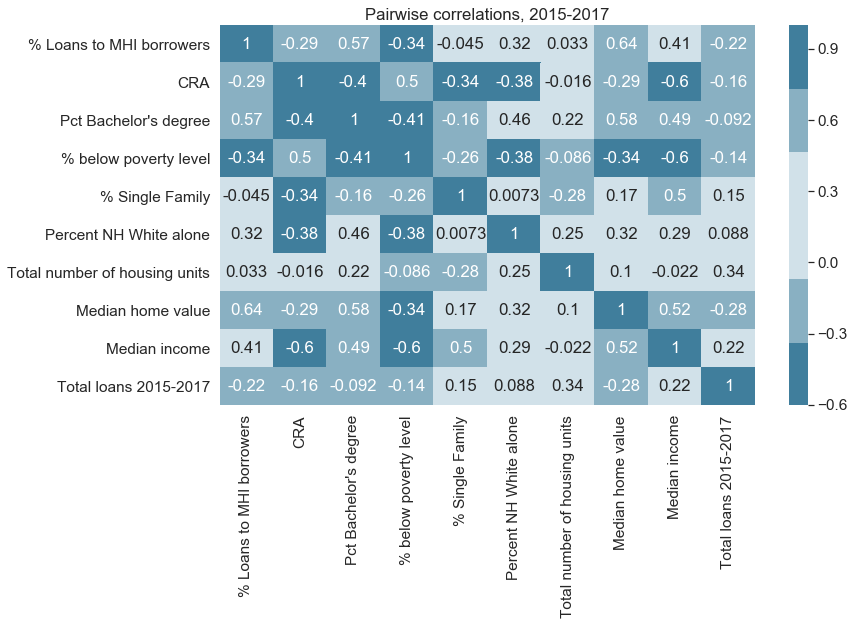

In [22]:
color = sns.diverging_palette(230, 230)
sns.set(font_scale=1.4)
plt.subplots(figsize=(12,7))
sns.heatmap(x_vars_151617_corr, annot=True, cmap=color);
plt.title("Pairwise correlations, 2015-2017")
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_151617_corr.png', bbox_inches="tight")


